In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras import backend as kb
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('/kaggle/input/amp-pd')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df_train_peptides = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv')
df_train_proteins = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv')
df_train_clinical = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')

In [3]:
def get_lin_reg(mat):
    if mat.shape[0] == 1:
        return 0, mat[0,1]
    
    X = mat[:,0]
    X = np.vstack([X, np.ones(len(X))]).T
    Y = mat[:,1]
    
    # res = np.dot(np.linalg.inv(X.T@X)@X.T, Y)            # This might be faster? (Uses pseudoinverse to calculate weights)
    res = np.around(np.linalg.lstsq(X,Y, rcond=None)[0])
    return res


def lin_reg_imputation(df, complete=False, style='mean'):
    global t0
    # res = [0]*len(df.patient_id.unique())       # To preallocate a list, might be faster?
    # i = 0                                       # If using preallocation
    res= []
    for patient, group in df.groupby('patient_id'):
        months = group['visit_month']
        for col in group:
            data = group[col]
            if data.isna().sum() not in (0, len(data)):
                m,b = get_lin_reg(pd.concat([months,data], axis=1).dropna().values)
                group[col].fillna(m*months + b, inplace=True)
        res.append(group)
        # res[i] = group                          # If using preallocation
        # i += 1                                  # If using preallocation
    df_linreg = pd.concat(res)
    if complete:
        if style=='mean':
            df_linreg.fillna(df_linreg.mean(), inplace=True)
        elif style=='zero':
            df_linreg.fillna(0, inplace=True)
        else:
            raise Exception(f'"{style}" is not a valid imputation method. Available options are "mean" or "zero"')
    return df_linreg


def test_data_prep(proteins, uniprot_ids, scaler, shown, concat=True):
    
    # Remove extra proteins
    new_uniprots = set(proteins.UniProt.unique())
    extra_prots = new_uniprots.difference(uniprot_ids)
    proteins = proteins.drop(extra_prots)
    print('removed extras')
    print(f'removed {extra_prots}')
    
    # Reshape
    protein_pivot = df_train_proteins.pivot(index='visit_id', columns='UniProt', values='NPX')
    protein_pivot = protein_pivot.reset_index()
    
    p_id, v_id = zip(*(v_id.split('_') for v_id in protein_pivot.visit_id.values))
    proteins = protein_pivot
    proteins.insert(1, 'patient_id', np.array(p_id).astype('int32'))
    proteins.insert(2, 'visit_month', np.array(v_id).astype('int32'))
    print('pivoted and merged')
    
    # Impute missing values
    if proteins.isna().sum().sum() > 0:
        protein_lr = lin_reg_imputation(proteins, complete=True)
        print('imputed')
        print(protein_lr.isna().sum().sum())
    else:
        protein_lr = proteins
    
    # Scale protein NPX values
    columns = protein_lr.columns
    sc = scaler
    protein_lr = pd.DataFrame(sc.transform(protein_lr.iloc[:,3:]), columns=columns[3:])
    protein_lr = pd.concat([proteins.iloc[:,:3], protein_lr], axis=1)
    print('scaled')
    
    # Reshape for LSTM
    months = [0,6,12,18,24,36,48,60,72,84]
    num_proteins=len(uniprot_ids)
    shown = months[:shown+1]
    X_iter = []
    sample_info = []
    for patient_id, group in protein_lr.groupby('patient_id'):
        X_iter.append([])
        sample_info.append(patient_id)
        verify_month = shown[-1] in group.visit_month.values
        for month in months:
            if month in shown and month in group.visit_month.values.astype('int'):
                X_iter[-1].append(*group[group.visit_month==month].iloc[:,3:].values)
            else:
                X_iter[-1].append(np.full(num_proteins,-1))
    X = np.array(X_iter)
    print('reshaped')
    
    if concat:
        X = np.concatenate(X, axis=0)
        print('concatenated')
        
    return X, sample_info, verify_month


def train_data_prep(clinical, proteins, concat=True):
    
    # Modify protein shape
    protein_pivot = df_train_proteins.pivot(index='visit_id', columns='UniProt', values='NPX')
    protein_pivot = protein_pivot.reset_index()
    print('pivoted')
    
    # Merge with UPDRS scores and remove medication state column
    updrs_protein = pd.merge(clinical.drop(['upd23b_clinical_state_on_medication'], axis=1), 
                             protein_pivot, 
                             on=['visit_id'])
    print('merged')
    
    # Impute missing values
    protein_data = updrs_protein.drop(['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'], axis=1)
    protein_lr = lin_reg_imputation(protein_data, complete=True)
    print('imputed')
    
    # Scale protein NPX values
    columns = protein_lr.columns
    sc = StandardScaler()
    protein_lr = pd.DataFrame(sc.fit_transform(protein_lr.iloc[:,3:]), columns=columns[3:])
    protein_lr = pd.concat([updrs_protein.iloc[:,:7], protein_lr], axis=1)
    print('scaled')
    
    # Remove useless rows from train data
    updrs_subset = protein_lr.iloc[:,:7]
    for month in (3,30,54,96,108):
        protein_lr.drop(protein_lr[protein_lr.visit_month == month].index, inplace=True)
    print('removed rows from protein_lr')
    
    # Reshape X and Y data for LSTM
    X_iter = []
    months = [0,6,12,18,24,36,48,60,72,84]
    num_proteins=227
    for i in range(len(months)):
        shown = months[:i+1]
        X_iter.append([])
        for patien_id, group in protein_lr.groupby('patient_id'):
            X_iter[-1].append([])
            for month in months:
                if month in shown and month in group.visit_month.values:
                    X_iter[-1][-1].append(*group[group.visit_month==month].iloc[:,7:].values)
                else:
                    X_iter[-1][-1].append(np.full(227,-1))

    Y_iter = []
    for i,month in enumerate(months):
        shown = months[:i+1]
        Y_iter.append([])
        for patient_id, group in updrs_subset.groupby('patient_id'):
            Y_iter[-1].append([])
            for month2 in [month, month+6, month+12, month+24]:
                if month2 in group.visit_month.values:
                    if group.isna().sum().sum() >0:
                        group.fillna(value=-1, inplace=True)
                    Y_iter[-1][-1].append(*group[group.visit_month==month2].iloc[:,3:].values)

                else:
                    Y_iter[-1][-1].append(np.full(4,-1))

    X = np.array(X_iter)
    Y = np.array(Y_iter)
    print(f'Reshaped\nX:{X.shape}\nY:{Y.shape}')
    
    # Split Y into 4, one for each UPDRS
    Y1, Y2, Y3, Y4 = np.split(Y, [1,2,3], axis=3)
    for i,data in enumerate([Y1, Y2, Y3, Y4]):
        print(f'UPDRS {i+1} shape: {data.shape}')
              
    if concat:
        X = np.concatenate(X, axis=0)
        Y1 = np.concatenate(Y1, axis=0)
        Y2 = np.concatenate(Y2, axis=0)
        Y3 = np.concatenate(Y3, axis=0)
        Y4 = np.concatenate(Y4, axis=0)
    
    return X, [Y1, Y2, Y3, Y4], sc
    

def SMAPE(y_true, y_pred):
    """
    Computes the Symmetric Mean Absolute Percentage Error (SMAPE) loss between y_true and y_pred.
    """
    mask = y_true!=-1
    y_pred = y_pred*kb.cast(mask,tf.float32)
    y_true = y_true*kb.cast(mask,tf.float32)
    
    # Comment out later
    # y_pred = y_pred+1
    # y_true = y_true+1

    epsilon = 0.1
    summ = kb.maximum(kb.abs(y_true) + kb.abs(y_pred) + epsilon, 0.5+epsilon)
    # summ = kb.abs(y_true) + kb.abs(y_pred)
    smape = kb.mean(kb.abs(y_pred - y_true) / summ * 2)
    return smape*100


def round_min_zero(nums):
    nums = np.around(nums).astype(int)
    return np.maximum(0,nums)


def check_smape(y_pred, y_true):
    y_pred = round_min_zero(y_pred)
    
    y_true = y_true.reshape(y_pred.shape)
    mask = y_true!=-1
    y_pred = y_pred*mask +1
    y_true = y_pred*mask +1
    
    summ = np.abs(y_pred) + np.abs(y_true)
    smape = np.mean(np.abs(y_pred-y_true) / summ *2)
    return smape*100


def sequential_model(input_shape, concat=True):
    print(SMAPE)
    if concat:
        shape = input_shape[1:]
    else:
        shape = input_shape[2:]

    lstm_model = Sequential()
    lstm_model.add(layers.Masking(mask_value=-1, input_shape=shape))
    lstm_model.add(layers.Conv1D(16,2,padding='same'))
    lstm_model.add(layers.LSTM(64))
    lstm_model.add(layers.Dense(4))
    lstm_model.compile(loss=SMAPE, optimizer='adam')
    lstm_model.summary()
    return lstm_model


#def API_model(input_shape, concat=True):
#    if concat:
#        shape = input_shape[1:]
#    else:
#        shape = input_shape[2:]
#    
#    inputs = layers.Input(shape)
#    mask = layers.Masking(mask_value=-1).compute_mask(inputs)
#    conv = layers.Conv1D(16,2,padding='same')(inputs)
#    lstm = layers.LSTM(64)(conv, mask=mask)
#    out = layers.Dense(4)(lstm)
#    model = Model(inputs,out)
#    model.compile(loss=SMAPE, optimizer='adam')
#    model.summary()
#    return model


def test_models(model_func, X_data, Y_data, eps=50, batch=16, kfold=None, test_size=0.2, concat=True):
    scores = []
    X_ftrain, X_ftest, Y_ftrain, Y_ftest = train_test_split(X_data, Y_data, shuffle=True, test_size=test_size)
    model = model_func(X_ftrain.shape)
    if kfold:
        kf = KFold(n_splits=kfold, shuffle=True)
        for train_index, test_index in kf.split(X_ftrain, Y_ftrain):
            X_train, X_test = X_ftrain[train_index], X_ftrain[test_index]
            Y_train, Y_test = Y_ftrain[train_index], Y_ftrain[test_index]
            model.fit(X_train,Y_train, epochs=eps, batch_size=batch)
            scores.append(check_smape(model.predict(X_test),Y_test))
        scores.append(check_smape(model.predict(X_ftest),Y_ftest))
    else:
        model.fit(X_ftrain,Y_ftrain, epochs=eps, batch_size=batch)
        scores.append(check_smape(model.predict(X_ftest),Y_ftest))
    return model, scores


def train_models(model_func, X_data, Y_data, eps=50, batch=16, kfold=None, test_size=0.2, concat=True):
    scores = []
    model = model_func(X_data.shape)
    if kfold:
        kf = KFold(n_splits=kfold, shuffle=True)
        for train_index, test_index in kf.split(X_data, Y_data):
            X_train, X_test = X_data[train_index], X_data[test_index]
            Y_train, Y_test = Y_data[train_index], Y_data[test_index]
            model.fit(X_train,Y_train, epochs=eps, batch_size=batch)
            scores.append(check_smape(model.predict(X_test),Y_test))
    else:
        model.fit(X_data,Y_data, epochs=eps, batch_size=batch)
        scores.append(check_smape(model.predict(X_data),Y_data))
    return model, scores

In [4]:
# Need list of proteins in train in case extra proteins in test API
train_uniprot_ids = set(df_train_proteins.UniProt.unique())

In [5]:
X, Y, scaler_object = train_data_prep(df_train_clinical, df_train_proteins)

pivoted
merged
imputed
scaled
removed rows from protein_lr
Reshaped
X:(10, 248, 10, 227)
Y:(10, 248, 4, 4)
UPDRS 1 shape: (10, 248, 4, 1)
UPDRS 2 shape: (10, 248, 4, 1)
UPDRS 3 shape: (10, 248, 4, 1)
UPDRS 4 shape: (10, 248, 4, 1)


<function SMAPE at 0x78a9045465f0>
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 10, 227)           0         
                                                                 
 conv1d (Conv1D)             (None, 10, 16)            7280      
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 28,276
Trainable params: 28,276
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
124/124 [==============================] - 3s 7ms/step - loss: 30.0500
Epoch 2/50
124/124 [==============================] - 1s 7ms/step -

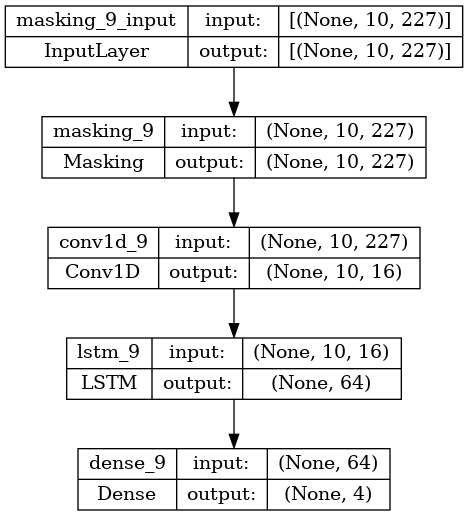

In [6]:
#Use results from this cell for the final paper******************************************************************************

for y in Y:
    sequential_split = test_models(sequential_model, X, y)
    sequential_kf3 = train_models(sequential_model, X, y, kfold=3)
    sequential_kf5 = train_models(sequential_model, X, y, kfold=5)

for i in [sequential_split, sequential_kf3, sequential_kf5]:
    print(i[1])
plot_model(sequential_split[0], show_shapes=True, show_layer_names=True)

In [7]:
trained_model, scores = zip(*[train_models(sequential_model, X, y, kfold=3) for y in Y])    

<function SMAPE at 0x78a9045465f0>
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_12 (Masking)        (None, 10, 227)           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 10, 16)            7280      
                                                                 
 lstm_12 (LSTM)              (None, 64)                20736     
                                                                 
 dense_12 (Dense)            (None, 4)                 260       
                                                                 
Total params: 28,276
Trainable params: 28,276
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
104/104 [==============================] - 4s 9ms/step - loss: 33.6074
Epoch 2/50
104/104 [==============================] - 1s 9ms/ste

In [8]:
for i in range(4):
    print(f'model: {trained_model[i]}\nscores: {scores[i]}\n')


model: <keras.engine.sequential.Sequential object at 0x78a8fa153910>
scores: [5.095059863439958, 5.058729776920125, 5.219820241468249]

model: <keras.engine.sequential.Sequential object at 0x78a8f91c5d50>
scores: [6.744517983409071, 7.630473940202817, 6.7591920352707335]

model: <keras.engine.sequential.Sequential object at 0x78a903c4db10>
scores: [3.9738598551273423, 4.739246440918109, 3.49064066465267]

model: <keras.engine.sequential.Sequential object at 0x78a903a688b0>
scores: [9.042829675876122, 9.076049606867509, 9.904487184373906]



In [9]:
def create_submission_df(predictions, ids, loop):
    updrs_list = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
    months = [0,6,12,18,24,36,48,60,72,84]
    month = months[loop]
    plus_list = [0,6,12,24]
    
    prediction_ids = []
    
    all_predictions = round_min_zero(predictions)
    for i,preds in enumerate(all_predictions):
        patient = 0
        prediction_ids.append([])
        preds = preds.reshape(4*len(preds))
        for j,pred in enumerate(preds):
            plus_month = plus_list[j%4]
            prediction_ids[-1].append('_'.join([str(ids[patient]),str(month),updrs_list[i], 'plus', str(plus_month), 'months']))
            patient += (j%4+1)//4
    
    dfs = []
    for pred_ids, pred in zip(prediction_ids, all_predictions):
        pred = pred.reshape(4*len(pred))
        pred_ids = np.array(pred_ids)
        dfs.append(pd.DataFrame({'prediction_id':pred_ids, 'rating':pred}).set_index('prediction_id'))

    return pd.concat(dfs)

In [10]:
import amp_pd_peptide_310
env = amp_pd_peptide_310.make_env()
iter_test = env.iter_test()

In [11]:
data = None
loop = 0
for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    if loop == 0:
        data = pd.read_csv(test_proteins)
    else:
        data = pd.concat([data, pd.read_csv(test_proteins)], axis=0)
    test_input, test_patients, correct_month = test_data_prep(data, train_uniprot_ids, scaler_object)
    print(correct_month)
    
    # Double and Triple check that data is fully imputed aka no nan values
    if test_input.isna().sum().sum() > 0:
        test_input.fillna(data.mean(), inplace=True)
        print('column mean imputation required')
    if test_input.isna().sum().sum() > 0:
        test_input.fillna(0, inplace=True)
        print('zero imputation required')
        print(test_input.head(10))
    print(test_input.shape)
    
    temp_results = [model.predict(test_input) for model in trained_model]
    
    
    sample_submission = create_submission_df(temp_results, test_patients, loop)
    
    
    # final line, outputs csv for submission. Need to pass in a dataframe.
    # columns are prediction_id and rating
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


TypeError: argument of type 'method' is not iterable